### Table of contents
1. [Introduction](#intro)
2. [Mutual Information with target](#mi)
3. [Feature analysis with PCA](#pca)
4. [Clusters](#cluter)
5. [Discussion](#disc)

### Introduction <a name='intro'>
In this post, I want to try to improve my previous predictions on the [February Tabular Playground Competition](https://www.kaggle.com/c/tabular-playground-series-feb-2021/overview). Previously, I applied various models on the data, using one-hot encoding on categorical variables. This time, let us dive deeper into feature selection/engineering. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/train.csv',index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)

In [3]:
train = df.copy()
y = train.pop('target')

In [4]:
# label encoding on categorical variables
for col in train.select_dtypes('object'):
    train[col], _ = train[col].factorize()

In [5]:
#  for mutual info, a boolean mask for discrete features is necessary for us
categorical = (train.dtypes==int)

### Mutual information with target <a name='mi'>
[Mutual information](https://en.wikipedia.org/wiki/Mutual_information) is a univariate quantity based on the concept of entropy. 

In [14]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

# helper function to display mutual information
def frame_mi_scores(X,y,discrete_features):
    mi_scores=mutual_info_regression(X,y,discrete_features=discrete_features)
    mi_scores=pd.Series(mi_scores,name='MI Scores', index=X.columns)
    mi_scores=mi_scores.sort_values(ascending=False)
    return mi_scores

# helper function to plot mutual information scores
def plot_mi_scores(scores):
    y = scores.sort_values(ascending=True)
    width = np.arange(len(y))
    ticks = list(y.index)
    plt.figure(figsize=(14,8))
    plt.barh(width,y)
    plt.yticks(width,ticks)
    plt.title('Mutual Information Scores')

# helper function to one-hot encode categorical variables
def one_hot(X,test):
    discrete = X.dtypes[X.dtypes=='object'].index
    oh = OneHotEncoder(handle_unknown='ignore',sparse=False)
    
    oh_X = pd.DataFrame(oh.fit_transform(X[discrete]))
    oh_X.index = X.index
    X_num = X.drop(discrete,axis=1)
    X_encoded = pd.concat([oh_X,X_num],axis=1)
    
    oh_test = pd.DataFrame(oh.transform(test[discrete]))
    oh_test.index = test.index
    test_num = test.drop(discrete,axis=1)
    test_encoded = pd.concat([oh_test,test_num],axis=1)
    
    return X_encoded, test_encoded
    
    
# function to evaluate performance
def score_data(X,y,model=XGBRegressor()):
    X_train, _ = one_hot(X,test)
    score = cross_val_score(model,X_train,y,cv=2,
                            scoring="neg_root_mean_squared_error")
    score = (-1)*score
    return score

In [7]:
mi_scores = frame_mi_scores(train,y,categorical)
mi_scores

cont8     0.012832
cat1      0.012001
cont0     0.011973
cat9      0.011252
cont11    0.007914
cont5     0.007900
cont12    0.007277
cont1     0.007117
cat2      0.006329
cont3     0.006201
cont9     0.005123
cat5      0.004825
cat8      0.004778
cat3      0.004625
cont13    0.004058
cont7     0.004028
cont10    0.002998
cont6     0.002445
cat6      0.002382
cat7      0.001187
cat0      0.001008
cont2     0.000986
cat4      0.000173
cont4     0.000000
Name: MI Scores, dtype: float64

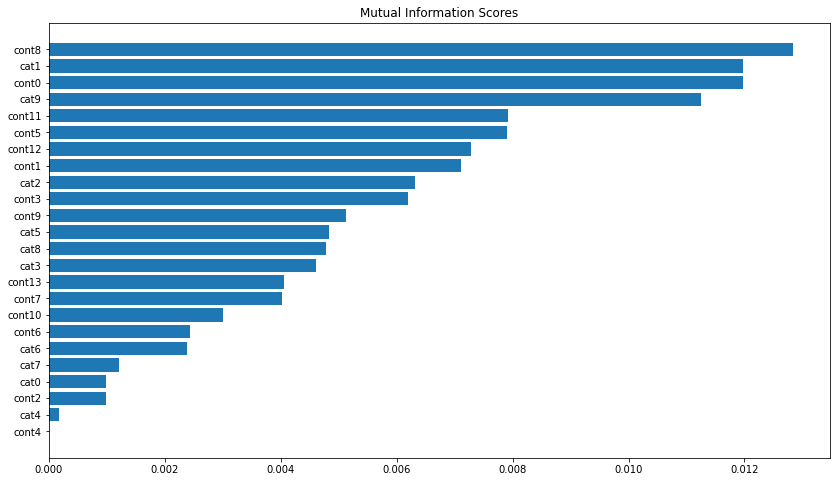

In [30]:
plot_mi_scores(mi_scores)

As we can see, the relationship between `target` and all feature columns are quite weak. The feature `cont4` seems to have almost no relationship with our `target`, from the point of view of mutual information.

### Feature analysis with PCA <a name='pca'>

In [11]:
# helper function to plot variance
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [75]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
numerical = train.dtypes[train.dtypes=='float64'].index
X_num = df.copy()[numerical]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
test_scaled = scaler.transform(test[numerical])

In [84]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
test_pca = pca.transform(test_scaled)
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca,columns=component_names,index=X_num.index)
test_pca = pd.DataFrame(test_pca,columns=component_names,index=test.index)
X_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
id,,,,,,,,,,,,,,
1,4.007152,-0.287137,-0.616210,-0.040970,-1.220582,-2.045058,0.422936,-0.945802,-0.490780,0.754603,0.175601,0.052521,-0.148215,-0.174724
2,0.370114,-1.242004,-1.620660,-0.599363,1.996433,1.025111,-1.074598,-0.056463,0.674771,1.158846,-0.813682,0.559756,-0.347718,0.012453
3,3.175671,-1.204480,-1.093005,-0.400499,-2.118989,0.669334,0.322556,-1.842585,-0.526955,-0.820925,-1.255360,0.098809,0.017490,0.324430
4,3.078185,-0.813904,0.289956,1.879460,-1.459988,-0.063743,-1.516448,-0.054198,-0.296987,-0.460323,-0.513670,0.504566,-0.244123,0.532357
6,-0.045967,2.030668,0.393629,-0.740670,0.605095,0.162002,-0.376066,0.889557,-0.253369,0.506481,0.261940,0.328952,-0.089354,-0.154388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,-2.803364,-1.111513,-1.069301,1.144713,-1.387580,-0.500638,-0.846170,0.902091,0.013936,0.651545,-0.851142,0.186040,-0.252218,0.280956
499996,-3.379632,-1.088119,1.238318,0.518752,0.850754,-0.019607,1.870482,0.563601,0.750439,-0.013130,-0.459452,0.234659,-0.184260,-0.045378
499997,-2.149592,0.018433,0.330000,-1.321653,-0.539887,0.034334,0.059224,0.196099,-0.159667,-0.259317,-0.486069,-0.962121,-0.243667,0.801325


The principal components are linear combinations of the original features. 

In [45]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X_num.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
cont0,0.337213,-0.099996,0.051681,0.120544,0.087794,-0.021652,-0.018058,-0.192973,-0.652248,0.223875,0.236608,-0.370247,0.340790,-0.169096
cont1,-0.039944,0.489351,0.024623,0.040668,-0.818938,0.009925,-0.233341,-0.080896,-0.146387,0.056546,0.005176,-0.006954,-0.013436,-0.006835
cont2,-0.173902,0.415358,0.027869,0.105741,0.204459,0.502824,0.369119,-0.550468,-0.011199,-0.219892,0.035274,0.004610,0.039980,-0.006067
cont3,0.164973,-0.354989,-0.047118,-0.138784,-0.128682,0.807055,-0.382353,0.080179,0.065507,0.009567,0.018077,-0.003636,0.003687,0.005434
cont4,-0.119142,-0.189663,0.227636,0.906849,-0.110121,0.110507,0.089267,0.195335,0.062250,0.009807,-0.010379,0.026116,0.013537,0.015275
cont5,0.377451,-0.037619,0.071628,0.054987,-0.047989,-0.098441,-0.029850,-0.207081,0.124702,-0.124707,0.091677,-0.008920,0.144153,0.855469
cont6,0.244949,0.379750,-0.111533,0.046754,0.172840,0.106567,-0.012018,0.591564,-0.270374,-0.535933,0.155944,0.034229,-0.053769,0.033686
cont7,0.218916,-0.205477,-0.083925,-0.180245,-0.387990,0.126537,0.804609,0.216112,-0.002335,0.070132,-0.023022,-0.059716,-0.025436,0.002866
cont8,0.354001,-0.092248,0.041680,0.078819,0.016255,-0.033319,0.007961,-0.228199,-0.332226,0.054644,-0.119486,0.713877,-0.400807,-0.082507
cont9,0.359156,0.055150,0.102294,0.090456,0.034670,-0.034321,-0.055288,-0.132846,0.122055,-0.109872,-0.382999,-0.562430,-0.569500,-0.109177


The next plot presents the amount of information contained in each of the principal components. 

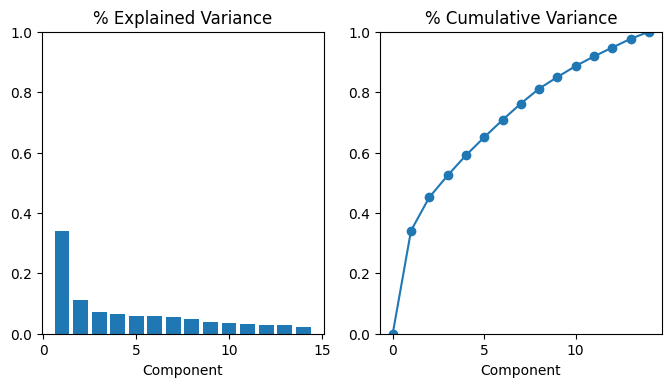

In [46]:
plot_variance(pca);

In [109]:
mutual_info_regression(X_pca,y)

array([0.00220991, 0.        , 0.00278606, 0.00032605, 0.00236544,
       0.00149745, 0.        , 0.        , 0.00044469, 0.00128214,
       0.00263009, 0.00225952, 0.00061506, 0.        ])

It seems that the mutual information scores for the principal components are not very significant. 

### Clusters <a name='cluster'>
We can also try to extract more information by grouping data points into clusters via `KMeans`. 

In [48]:
from sklearn.cluster import KMeans

In [66]:
kmeans = KMeans(n_clusters=5,n_init = 10)
train['Cluster'] = kmeans.fit_predict(train)

Now, let us look at the mutual information score of the cluster classification and the target. 

In [85]:
train.Cluster = train.Cluster.astype('int64')
categorical = (train.dtypes=='int64')

cluster_mi = frame_mi_scores(train,y,categorical)

In [86]:
cluster_mi

cont8      0.012832
cat1       0.011977
cont0      0.011973
cat9       0.011264
cont11     0.007915
cont5      0.007900
cont12     0.007276
cont1      0.007116
cat2       0.006324
cont3      0.006202
cont9      0.005123
cat5       0.004823
cat8       0.004785
cat3       0.004638
cont13     0.004058
cont7      0.004028
Cluster    0.003670
cont10     0.002998
cont6      0.002445
cat6       0.002382
cat7       0.001198
cat0       0.001014
cont2      0.000986
cat4       0.000173
cont4      0.000000
Name: MI Scores, dtype: float64

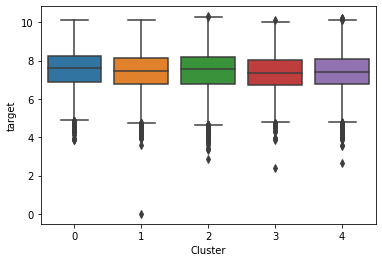

In [105]:
sns.boxplot(data=pd.concat([train,y],axis=1),x='Cluster',y='target');

Unfortunately, it seems that the clustering does not seem to be very indicative to the target, as shown by the mutual information score, as well as the above plot. 

### Making predictions

In [110]:
# obtain processed data
X_encoded, test_encoded = one_hot(df.drop('target',axis=1),test)
X_encpca = pd.concat([X_encoded,X_pca],axis=1)
test_encpca = pd.concat([test_encoded,test_pca],axis=1)

In [112]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X_encpca,y,train_size=0.8)
gbm = XGBRegressor(n_estimators=1000,learning_rate=0.1)
gbm.fit(X_train,y_train,early_stopping_rounds=5,
        eval_set=[(X_val,y_val)],verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=6, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [113]:
# making and saving prediction
gbm_preds = pd.DataFrame(gbm.predict(test_encpca),index=test.index,
                        columns=['target'])
gbm_preds.to_csv('predictions/gbmpca.csv')
gbm_preds

,target
id,
0,7.581488
5,7.800866
15,7.607448
16,7.504133
17,7.335790
...,...
499987,7.466197
499990,7.346903
499991,7.469084


### Discussion <a name='disc'>
After trying to add in PCA features, unfortunately, the submission score did not improve. So, perhaps, after adding the components, there are redundancies in our data, and it is not clear to me how we should select the features. However, the score did improve when I changed the learning rate to 0.1, which suggests there is room to improve in hyperparameters tuning. 